<a href="https://colab.research.google.com/github/ACTCollaboration/DR6_Notebooks/blob/main/ACT_DR6_ymap_CIB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Tutorial for investigating the potential CIB contamination with ACT DR6 Compton y map when cross-correlated with LSS**

*Written by Ola Kusiak and the ACT collaboration*

---
This notebook illustartes how the CIB contamination present in the Compton-y map can affect the cross-correlation with LSS. It is important to carefully investigate the CIB, as well as other potential contaminants in the measurements.

This notebook uses the standard y map from the DR6 data release, as presented in Coulton et al. 2023, [on arXiv](https://https://arxiv.org/abs/2307.01258), as well as two maps that deproject CIB with different values of the CIB SED parameters (available on NERSC). The DR6 products are:
*  standard Compton-y map
* Compton-y map with CIB deprojected ($\beta_{\rm CIB}=1.4$ and $T_{\rm CIB}=10.7$K)
* Compton-y map with CIB deprojected ($\beta_{\rm CIB}=1.2$ and $T_{\rm CIB}=24$K)
* standard DR6 mask  
* 1.6' effective beam (applied to all y maps)

As the LSS field, we chose the Dark Energy Survey (DES) Year-3 publicly available weak lensing map and mask, downloaded from [here](https://des.ncsa.illinois.edu/releases/y3a2/Y3massmaps) (both reprojected from Healpix to CAR):
* DES weak lensing (kappa) map bin 4
* DES mask

All maps used in this notebook were downgraded for efficiency.
The point of this notebook is solely to illustrate the effect of the CIB contamination in the Compton-y map, and the methods presented here to compute the cross-correlations require additional refinements and tests.  

**Load the necessary packages**

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...


In [1]:
import condacolab #sometimes this cell doesn't work on the first try, please re-try
condacolab.check()


✨🍰✨ Everything looks OK!


In [2]:
# Install pymaster
%%capture
!conda install -c conda-forge namaster

In [3]:
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt

**For More Information**

More examples of how to use Pixell and the ACT data products can be found in the [ACT DR4 and DR5 Notebooks](https://github.com/ACTCollaboration/DR4_DR5_Notebooks/tree/master), Pixell itself can be found [here](https://github.com/simonsobs/pixell/tree/master) and the full list of public ACT data is on [LAMBDA](https://lambda.gsfc.nasa.gov/product/act/actadv_dr6_compton_maps_get.html)

In [4]:
# Install pixell
%%capture
!pip install pixell

In [5]:
from pixell import enmap, enplot, utils, curvedsky

def eshow(x,**kwargs):
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

In [6]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


**Load the maps**

First, we will inspect the necessary data products: the Compton-y map and DES map, along with their masks.  
Let's start by downloading the necessary maps with the wget command. These maps will be put in your Google Drive.

In [7]:
%%capture
#ACT DR6
!wget https://phy-act1.princeton.edu/public/data/dr6_ilc_v1/beam_ILC.txt
!wget https://phy-act1.princeton.edu/public/data/dr6_ilc_v1/downgraded10_ilc_SZ_yy.fits
#!wget https://phy-act1.princeton.edu/public/data/dr6_ilc_v1//ilc_SZ_yy.fits #full map
!wget https://phy-act1.princeton.edu/public/data/dr6_ilc_v1/downgraded10_ilc_SZ_deproj_cib_1.2_24.0_yy.fits
!wget https://phy-act1.princeton.edu/public/data/dr6_ilc_v1/downgraded10_ilc_SZ_deproj_cib_1.4_10.7_yy.fits
#!wget https://phy-act1.princeton.edu/public/data/dr6_ilc_v1/downgraded10_outputMask_wide_mask_GAL070_apod_1.50_deg_wExtended.fits #full mask
!wget https://phy-act1.princeton.edu/public/data/dr6_ilc_v1/wide_mask_GAL080_apod_1.50_deg_wExtended.fits

#DES
!wget https://phy-act1.princeton.edu/public/data/dr6_ilc_v1/downgraded10_DES_kappa4_in_car_interp_full.fits
!wget https://phy-act1.princeton.edu/public/data/dr6_ilc_v1/downgraded10_DES_unpodized_mask_in_car_interp.fits

Let's load the path to your Google Drive, where all the maps we just downloaded with the wget command should be present.

In [8]:
# Path to data
gdrive_path = "/content/drive/My Drive/" # enter the folder where you've loaded the maps

# Check if you can cd into this folder
%cd /content/drive/My Drive/


/content/drive/My Drive


The first map is the DR6 default Compton-y map presented in Coulton et al. 2023, [on arXiv](https://https://arxiv.org/abs/2307.01258).

All maps presented in this notebook were downgraded for computational purposes.  The downgrading operation was performed with the [pixell.enmap.downgrade()](https://pixell.readthedocs.io/en/latest/reference.html#pixell.enmap.downgrade) pixell function with a downgrading factor of 10. You can download full versions of the maps from [LAMBDA](https://lambda.gsfc.nasa.gov/product/act/actadv_dr6_compton_maps_get.html).



In [9]:
# Load the default ACT DR6 Compton-y map, downgraded 10 times
ymap = enmap.read_map(gdrive_path +"downgraded10_ilc_SZ_yy.fits") #downgraded map
ymap.shape

(1032, 4320)

In [10]:
# Alternatively, it's possible to load the full map, and downgrade it
# ymap_full = enmap.read_map(gdrive_path +"ilc_SZ_yy.fits") #full map
# ymap = enmap.downgrade(ymap_full,10)

In [11]:
# Similarly, load the downgraded DR6 mask
ymask = enmap.read_map(gdrive_path+"downgraded10_outputMask_wide_mask_GAL070_apod_1.50_deg_wExtended.fits")

# Also, load the DR6 beam (1.6 arcmin)
ell_beam, beam = np.loadtxt(gdrive_path +"beam_ILC.txt").T


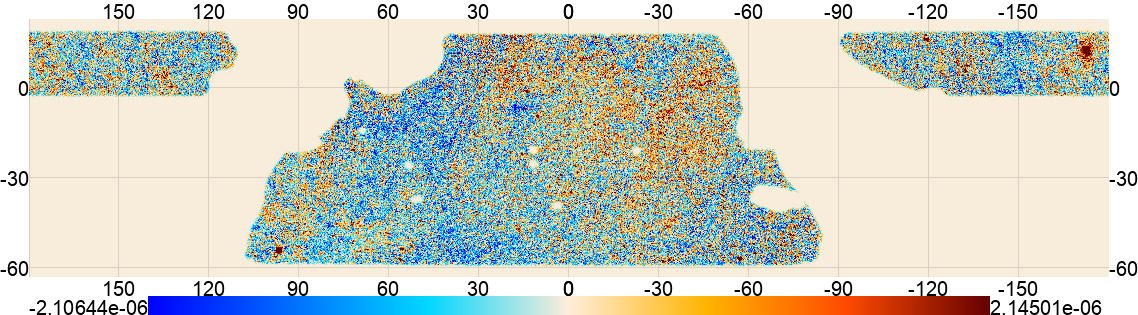

In [12]:
# Show the map
eshow(ymask*ymap, **{"downgrade": 4, "colorbar":True, "ticks":30})



Below we load the DES-Y3 weak lensing map, downloaded from [here](https://des.ncsa.illinois.edu/releases/y3a2/Y3massmaps). We chose the "KS" reconstruction methods for the tomographic galaxy redshift bin 4. The map was first reprojected from the Healpix format to CAR with the [pixell.reproject.healpix2map()](https://pixell.readthedocs.io/en/latest/reference.html#pixell.reproject.healpix2map) function, and then downgraded.

In [13]:
# Load the DES map
des_map = enmap.read_map(gdrive_path +"downgraded10_DES_kappa4_in_car_interp_full.fits")

# Load the DES mask
des_mask = enmap.read_map(gdrive_path +"downgraded10_DES_unpodized_mask_in_car_interp.fits")


In [14]:
# Combine the two masks
mask = ymask*des_mask

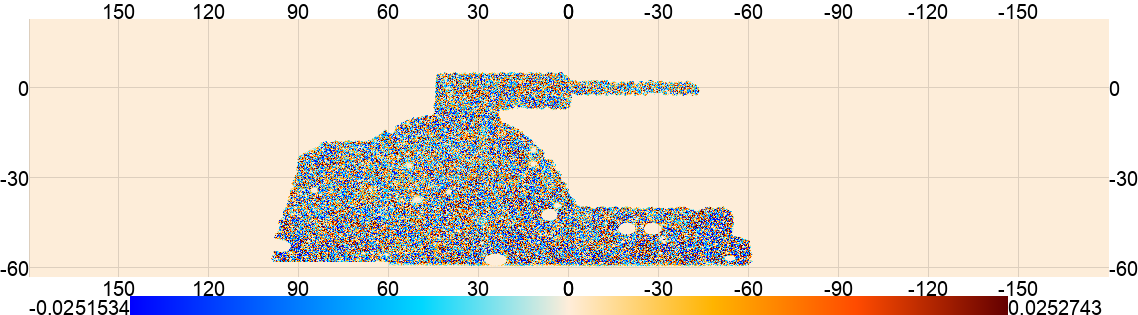

In [15]:
# Show the map
eshow(mask*des_map, **{"downgrade": 4, "colorbar":True, "ticks":30})

**Namaster**

To compute the cross-power spectra between the DR6 Comton-y maps and DES data, we will use the [pymaster](https://namaster.readthedocs.io/en/latest/index.html) code (python implementation of NaMaster). We will follow the simple pseudo-Cl example, as shown [here](https://namaster.readthedocs.io/en/latest/sample_simple.html).



Let's start by defining the Namaster's field for the two maps that we want to correlate.

In [16]:
# Define Namaster fields for each map
f_y = nmt.NmtField(mask, [ymap], beam = beam, wcs=ymap.wcs, n_iter=0) # deconvolve the beam in the DR6 ymap
f_des = nmt.NmtField(mask, [des_map], wcs=des_map.wcs, n_iter=0)

Now let's define the binning for our cross-correlation, i.e., the central values for each bin.

In [17]:
# In our case, we want to start from specific ellmin--use the nmt.NmtBin.from_edge() function
ellmin = 30  # start from ell=30 (fsky~0.10)
ellmax = 1630
binwidth= 200

# Start by defining the edges of each bin
ell_ini = np.arange(ellmin+1, ellmax+1, binwidth)
ell_end = np.arange(ellmin+binwidth, ellmax+binwidth, binwidth)
print(ell_ini)
print(ell_end)

# Initialize Namaster binning and get the central ells
bins=nmt.NmtBin.from_edges(ell_ini=ell_ini, ell_end=ell_end, is_Dell=True) #request the Namaster output as D_ell=ell*(ell+1)*C_ell/2pi
ell_nmt= bins.get_effective_ells()
print("Namaster bins:", ell_nmt)

[  31  231  431  631  831 1031 1231 1431]
[ 230  430  630  830 1030 1230 1430 1630]
Namaster bins: [ 130.  330.  530.  730.  930. 1130. 1330. 1530.]


Now we are ready to compute the cross-correlation. This can be done with nmt.compute_full_master function. This computation takes about 1 minute, alternatively you can load precomputed values.

In [18]:
# Compute the power spectra with Namaster -- this might take a while!
dl_ykappa = nmt.compute_full_master(f_y, f_des, bins)

In [19]:
# Precomputed dl_ykappa values -- load them instead if you don't want to wait for the previous cell to run
#dl_ykappa = np.array([[4.04671392e-10, 1.05115566e-09, 1.19114070e-09, 1.67113102e-09, 1.67523508e-09, 8.88345961e-10, 2.14709824e-09, 2.65362992e-09]])


Plot the cross-correlation between the DR6 Compton-y map and DES kappa map. It is of course lacking errorbars but we can get a sense of how the signal looks like.

It is worth remembering that the instrumental noise in the two maps is completely independent, so the increase in cross-correlation signal means that the computation is picking up on correlated small-scale signal in the y and kappa map, e.g. from galaxy clusters that induce both a y and lensing signal.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


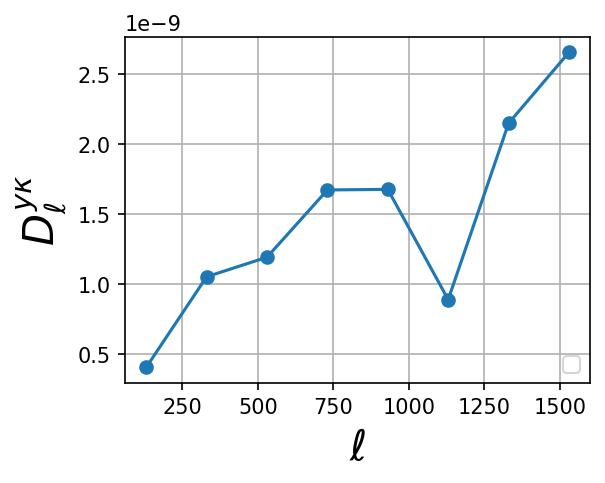

In [28]:
nmt.NmtBin# Plot the results
plt.subplots(figsize=(4, 3), dpi=150)
plt.plot(ell_nmt, dl_ykappa[0], "-o")
plt.xlabel(r'$\ell$', fontsize=20)
plt.ylabel(r'$D_\ell^{y \kappa}$', fontsize=20)
plt.legend(loc='lower right', ncol=2, labelspacing=0.1)
plt.grid()
plt.show()

**Compton-y map with CIB deprojected**

The DR6 map we investigated so far was constructed with the Needlet Internal Linear Combination (NILC) method, which preserves the Compton-y signal but does not ensure this map is free of foregrounds.
One of the most important contaminants is the Cosmic Infrared Background (CIB)--thermal emission sourcing from star-forming galaxies, that peaks around redshift z=2. If CIB is present in the Compton-y map, it can correlate with the LSS, and bias our intended y x LSS measurement.

Let's consider the standard method to mitigate the effect of the CIB, i.e., the CIB deprojections during the NILC procedure.

**CIB**

The CIB intensity can be written as the product of the frequency-dependent SED part and the template of the CIB anisotropies

 $ I^{\rm CIB}_{\nu} ( \hat{n} ) = \Theta^{\rm CIB}_{\nu} A^{\rm CIB} (\hat{n})$,


 where for the model for the CIB SED, $\Theta^{\rm CIB}_{\nu}$, one usually considers the modified blackbody (MBB) model, which is written down as

 $\Theta^{\rm CIB}_{\nu} =  \nu^\beta B_{\nu} (T_{\rm CIB} ) =   \nu^\beta \frac{2h\nu^3}{c^2} \frac{1}{e^\frac{hv}{k_B T_{\rm CIB}}-1} $,

where $B_{\nu} (T)$ is the Planck function, and $\beta_{\rm CIB}$ and $T_{\rm CIB}$ are two free CIB SED parameters, the spectral index and the temperature of the CIB, respectively.


CIB can be deprojected (=removed) during construction of the Compton-y map,assuming some SED for the CIB field, e.g., the MBB. However, it is known that MBB is not the exact model for CIB SED, and the parameters $\beta_{\rm CIB}$ and $T_{\rm CIB}$ are pooorly constrained.

Below we investigate how deprojecting CIB in the Compton-y can affect the final cross-correlation with LSS.  Let's start by loading two CIB-deprojected DR6 y maps, which assume different values for the MBB parameters.  


In [21]:
# Load the CIB-deprojected maps, also downgraded 10 times

# beta_CIB=1.4, T_CIB=10.7K
ymap_cib = enmap.read_map(gdrive_path +"downgraded10_ilc_SZ_deproj_cib_1.4_10.7_yy.fits")
# beta_CIB=1.2, T_CIB=24K
ymap_cib2 = enmap.read_map(gdrive_path +"downgraded10_ilc_SZ_deproj_cib_1.2_24.0_yy.fits")

In [22]:
# Create the Namaster fields
f_y_cib = nmt.NmtField(mask, [ymap_cib], beam =beam, wcs=ymap_cib.wcs, n_iter=0)
f_y_cib2 = nmt.NmtField(mask, [ymap_cib2], beam =beam, wcs=ymap_cib2.wcs, n_iter=0)

In [23]:
# Compute the power spectra with Namaster
dl_cib = nmt.compute_full_master(f_y_cib, f_des, bins) # with the same binning as for dl_ykappa

In [24]:
dl_cib2 = nmt.compute_full_master(f_y_cib2, f_des, bins) # with the same binning as for dl_ykappa

In [25]:
# Or simply load precomputed values
#dl_cib = np.array([[3.57234204e-10, 9.08246492e-10, 9.07987265e-10, 1.09517923e-09, 1.10576153e-09, 4.11329543e-10, 1.32450838e-09, 1.96336925e-09]])
#dl_cib2 = nparray([[3.85834687e-10, 1.01620573e-09, 1.19524722e-09, 1.61528411e-09, 1.70421006e-09, 8.48305366e-10, 2.01013962e-09, 2.49041182e-09]])

Let's plot the results. Again, we don't have errorbars yet, but we can already see how deprojecting CIB can affect the cross-correlation.

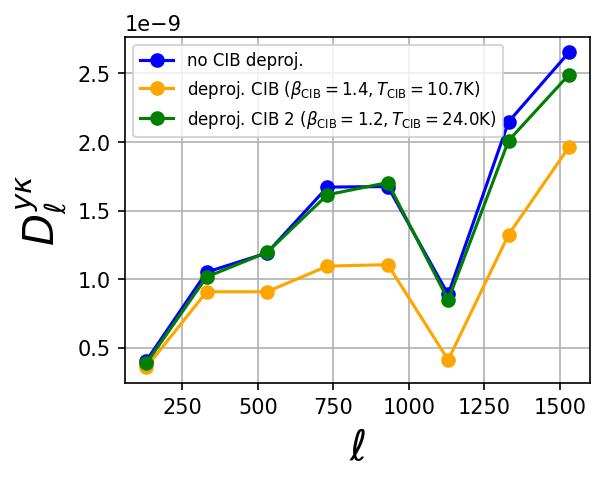

In [26]:
plt.subplots(figsize=(4, 3), dpi=150)
plt.plot(ell_nmt, dl_ykappa[0], "-o", color="blue", label='no CIB deproj.')
plt.plot(ell_nmt, (dl_cib[0]), "-o", color="orange",label=r'deproj. CIB ($\beta_\mathrm{CIB}=1.4, T_\mathrm{CIB}=10.7$K)')
plt.plot(ell_nmt, (dl_cib2[0]), "-o", color="green", label=r'deproj. CIB 2 ($\beta_\mathrm{CIB}=1.2, T_\mathrm{CIB}=24.0$K)')
plt.xlabel('$\ell$', fontsize=20)
plt.ylabel('$D_\ell^{y \kappa}$', fontsize=20)
# plt.legend(loc='lower right', ncol=2, labelspacing=0.1)
plt.legend(loc='upper left', fontsize=8)
plt.grid()
plt.show()

You can already see that for the map that deprojects the CIB with beta_CIB=1.4, T_CIB=10.7K, there is a noticeable difference compared to the default Compton-y map. On the other hand, the map with beta_CIB=1.2, T_CIB=24K seems to be very close. These differences point to the fact that the CIB model cannot capture the realistic variations in the CIB SED, which more realistically would vary with scale and redshift.

**Add Namaster Errorbars**

There is different noise in every CIB-deprojected map. To quantify how much of the difference is due to these noise fluctuations versus due to differences in the amount of deprojected signal, let's add the errorbars.
We will do this by computing the Gaussian estimate of the covariance with Namaster, as shown in this [example](https://namaster.readthedocs.io/en/latest/sample_covariance.html).

This is the longest computation in the notebook and will take around 5 minutes per cross-correlation. If you don't want to wait, you can scroll to the last cell before the plot, and simply load precomputed errorbar values.

To compute the Namaster covariance, we need estimates of the auto- and cross-power spectra between our maps defined at every ell to pass to the nmt.gaussian_covariance() object. The Namaster example uses precomputed theory predictions. To make things easier, we will compute the power spectra and interpolate.

In [ ]:
# First, define a function that computes Namaster power spectra between two fields, and interpolates the value at every ell.
from scipy import interpolate
def interpolate_cl(field1, field2, nmt_bin_width, ell_interpol_max):
    # Define new binning (has to be in C_ell)
    b = nmt.NmtBin.from_lmax_linear(ell_interpol_max+100, nmt_bin_width, is_Dell=False)
    ell= b.get_effective_ells()

    # #Compute new Cl's cl_inter to interpolate
    cl = nmt.compute_full_master(field1, field2, b)

    #set cl(ell=1) to zero to avoid extrapolation
    cl2 = np.insert(cl,[0,0],[0,0] )
    ell2 = np.insert(ell,[0,0],[0,1])

    #interpolate
    ell_new=np.arange(0., ell_interpol_max, 1) #up to ell_interp_max
    f=interpolate.interp1d(ell2, cl2)
    cl_interpolate=f(ell_new)

    return cl_interpolate, ell_new


In [ ]:
interp_bin_width =10
ELLMAX = 1700 #interpolate to larger ellmax than the measured cross-correlation

cl_12, ell_inter = interpolate_cl(f_y, f_des, nmt_bin_width=interp_bin_width, ell_interpol_max=ELLMAX)
cl_11, ell_inter = interpolate_cl(f_y, f_y, nmt_bin_width=interp_bin_width, ell_interpol_max=ELLMAX)
cl_22, ell_inter = interpolate_cl(f_des, f_des, nmt_bin_width=interp_bin_width, ell_interpol_max=ELLMAX)
cl_21, ell_inter =  cl_12, ell_inter  #same as cl_12


Now we are ready to compute the Namaster covariance.

This is the longest computation in this notebook, and will take about 5 minutes.

In [ ]:
# Workspace
w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f_y, f_des, bins)

# Gaussian estimate of the covariance
cw = nmt.NmtCovarianceWorkspace()
cw.compute_coupling_coefficients(f_y, f_des, f_y, f_des, lmax=ELLMAX-1) # lmax needs to be < len(cl1_interpolate)

# Compute the covariance
n_bins=len(ell_nmt) # number of bins
covar = nmt.gaussian_covariance(cw, 0, 0, 0, 0, [cl_11],[cl_12],[cl_21], [cl_22], w, wb=w).reshape([n_bins, 1,n_bins, 1])
covariance = covar[:, 0, :, 0]

# Get the errorbars
sigma=np.sqrt(covariance.diagonal())

Let's do the same for the cross-correlation with the y map that deprojects the CIB with $\beta_{\rm CIB}$=1.4 and $T_{\rm CIB}$=10.7K.

In [ ]:
# Compute the errobars for the y x g with the CIB-deprojected y-map

# Interpolate
cl_12_cib, ell_inter = interpolate_cl(f_y_cib, f_des, nmt_bin_width=interp_bin_width, ell_interpol_max=ELLMAX)
cl_11_cib, ell_inter = interpolate_cl(f_y_cib, f_y_cib, nmt_bin_width=interp_bin_width, ell_interpol_max=ELLMAX)
cl_22_cib, ell_inter =  cl_22, ell_inter #interpolate_cl(f_des, f_des, nmt_bin_width=interp_bin_width, ell_interpol_max=ELLMAX)
cl_21_cib, ell_inter =  cl_12_cib, ell_inter  #same as cl_12

# Workspace
w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f_y_cib, f_des, bins)

# Gaussian estimate of the covariance
cw = nmt.NmtCovarianceWorkspace()
cw.compute_coupling_coefficients(f_y_cib, f_des, f_y_cib, f_des, lmax=ELLMAX-1)

# Compute the covariance

covar = nmt.gaussian_covariance(cw, 0, 0, 0, 0, [cl_11_cib],[cl_12_cib],[cl_21_cib], [cl_22_cib], w, wb=w).reshape([n_bins, 1,n_bins, 1])
covariance = covar[:, 0, :, 0]

# Get the errorbars
sigma_cib=np.sqrt(covariance.diagonal())

In [ ]:
# Load precomputed values for sigma and sigma_cib
# sigma = np.array([3.61267533e-11, 9.10480729e-11, 1.55608696e-10, 2.26709337e-10, 3.01966249e-10, 3.79656830e-10, 4.46974729e-10, 5.01872869e-10])
# sigma_cib = np.array([4.77373685e-11, 1.19255378e-10, 1.91052255e-10, 2.67405991e-10, 3.46983885e-10, 4.28655479e-10, 4.95957417e-10, 5.46411618e-10])

Now, let's plot the two cross-correlations with Namaster errorbars.

There is a clear difference between the CIB-deprojected and the default y-map. The CIB-deprojected map (in this case) has a systematically lower signal across all $\ell$. The fourth data point is statistically inconsistent between the two maps.

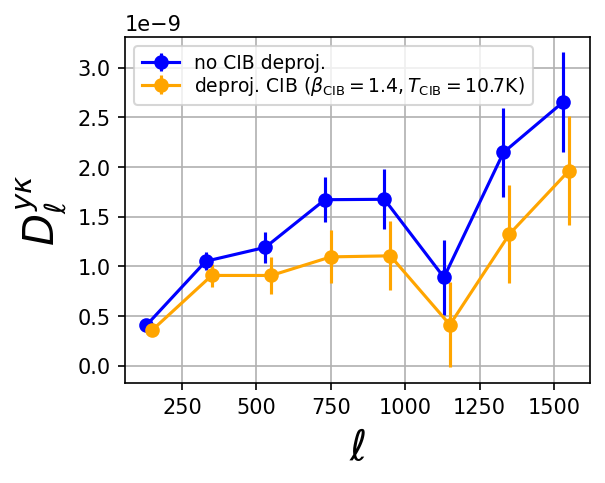

In [ ]:
plt.subplots(figsize=(4, 3), dpi=150)
plt.errorbar(ell_nmt, dl_ykappa[0], sigma,  fmt ="o-", color="blue", label='no CIB deproj.')
plt.errorbar(ell_nmt+20, (dl_cib[0]), sigma_cib,  fmt ="o-", color="orange", label=r'deproj. CIB ($\beta_\mathrm{CIB}=1.4, T_\mathrm{CIB}=10.7$K)') #artifially offset the points for visual purposes
plt.xlabel('$\ell$', fontsize=20)
plt.ylabel('$D_\ell^{y \kappa}$', fontsize=20)

plt.legend(loc='upper left', ncol=1, labelspacing=0.1, fontsize=9)
plt.grid()
plt.show()

This is just an illustration of how removing the CIB can affect the cross power spectrum with LSS! Deprojecting CIB with different values of $\beta_{\rm CIB}$ and $T_{\rm CIB}$ can yield very different results. In this case the change is not dramatic, though it is visible by eye. For other LSS samples the effect can be larger/smaller. Finding the correct values of $\beta_{\rm CIB}$ and $T_{\rm CIB}$ that characterize the CIB field for a given sample might be a significant challenge.

Sometimes the simple deprojection might not be enough to mitigate the effect of the CIB contamination. In that case, we recommend using the first-moment deprojected maps, which deproject not only the CIB, but also the first-moment of the Taylor expansion of the SED with respect to either $\beta_{\rm CIB}$ and $T_{\rm CIB}$, as discussed in Coulton et al.  We find that these maps are generally stable to the exact choice of the CIB parameters.

It is important to note that the CIB is just one of the contaminants that can be present in the Compton-y map, which can correlate with LSS, and bias the final measurement. Other examples include non-masked radio sources, the ISW effect, or CO lines.  